In [1]:
import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../')

import read_trace
import cuda_timeline
from avgblkmodel import *
import cke
from df_util import *
#from model_cke import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# gpu info

In [2]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

# 2 stream info

In [3]:
# 10M for mem_mem : where the h2d between streams are overlapped
trace_file = 'trace_10M_s1.csv'
trace_file_2cke = 'trace_h2d_h2d_ovlp.csv'

df_trace = read_trace.trace2dataframe(trace_file) # read the trace to the dataframe
df_trace_2cke = read_trace.trace2dataframe(trace_file_2cke)

In [4]:
#df_trace

In [5]:
#cuda_timeline.plot_trace(df_trace)

In [6]:
#df_trace_2cke

In [7]:
#cuda_timeline.plot_trace(df_trace_2cke)

# 1cke - read trace and reset the timeline

In [8]:
df_single_stream = read_trace.get_timing(df_trace)

In [9]:
#df_single_stream

In [10]:
df_s1 = read_trace.reset_starting(df_single_stream)

In [11]:
#df_s1

### 2cke case

In [12]:
df_2stream = read_trace.get_timing(df_trace_2cke)

In [13]:
# df_2stream

In [14]:
tot_runtime = read_trace.getTotalRuntime(df_2stream)
print tot_runtime

37.784463


# 2 cke

In [15]:
stream_num = 2

# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num, h2d_ovlp_th = H2D_H2D_OVLP_TH)

In [16]:
#df_cke_list[0]

In [17]:
#df_cke_list[1]

### sort

In [18]:
df_all_api = cke.init_sort_api_with_extra_cols(df_cke_list)

In [19]:
#df_all_api

In [20]:
#df_all_api.loc[df_all_api.stream_id == 0]

In [21]:
# print df_all_api.iloc[0]
# print df_all_api.iloc[1]

In [22]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,6.436815,h2d,38146.973,0.0,sleep,5926.373991,0.0,38146.973,0.0,0.0,0.0
4,3.158431,9.595246,h2d,38146.973,1.0,sleep,5926.373991,0.0,38146.973,0.0,0.0,0.0
1,6.438031,12.868030,h2d,38146.973,0.0,sleep,5932.656133,0.0,38146.973,0.0,0.0,0.0
5,9.596462,16.026461,h2d,38146.973,1.0,sleep,5932.656133,0.0,38146.973,0.0,0.0,0.0
2,12.879518,14.156136,kern,0.000,0.0,sleep,0.000000,0.0,0.000,0.0,0.0,0.0
3,14.162920,20.432566,d2h,38146.973,0.0,sleep,6084.390251,0.0,38146.973,0.0,0.0,0.0
6,16.037949,17.314567,kern,0.000,1.0,sleep,0.000000,0.0,0.000,0.0,0.0,0.0
7,17.321351,23.590997,d2h,38146.973,1.0,sleep,6084.390251,0.0,38146.973,0.0,0.0,0.0


In [23]:
# pick the 1st sleep call and wake up
r1 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r1)

# pick another in the sleep mode, if it is from the same stream, there is non ovlp
r2 = cke.pick_first_in_sleep(df_all_api)
df_all_api = SetWake(df_all_api, r2)
#print('r2 {}'.format(r2))

# check concurrency
conc = cke.check_cc(df_all_api, r1, r2)

# concurrency
if conc == 1:
    df_all_api = cke.update_before_conc(df_all_api, r1, r2)
    # set r2 to wake
    df_all_api = SetWake(df_all_api, r2)
    

In [24]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,6.436815,h2d,38146.973,0.0,wake,5926.373991,18718.04333,19428.92967,3.158431,0.0,0.0
4,3.158431,9.595246,h2d,38146.973,1.0,wake,5926.373991,0.00000,38146.97300,3.158431,0.0,0.0
1,6.438031,12.868030,h2d,38146.973,0.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.0
5,9.596462,16.026461,h2d,38146.973,1.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.0
2,12.879518,14.156136,kern,0.000,0.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.0
3,14.162920,20.432566,d2h,38146.973,0.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.0
6,16.037949,17.314567,kern,0.000,1.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.0
7,17.321351,23.590997,d2h,38146.973,1.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.0


In [25]:
# #print df_all_api.shape[0]


# # if check_coming_stream:
# #     if curapi == 'h2d' and nextapi == 'h2d':
# #         print('h2d_h2d')
# #         run_h2d_mod = 1
# #     if curapi == 'kern' and nextapi == 'kern':
# #         print('kern_kern')
# #         run_ker_mod = 1
# #     if curapi == 'd2h' and nextapi == 'd2h':
# #         run_d2h_mod = 1
# #         print('d2h_d2h')
        
# if run_h2d_mod == 1:
#     no_ovlap_time = nextapi_start - curapi_start
#     # use the org bw to transfer
#     curr_trans = df_all_api.iloc[0]['bw'] * no_ovlap_time
#     #print('curr_trans : {}'.format(curr_trans))
    
#     # update the bytes_done
#     df_all_api = UpdateCell(df_all_api, 
#                             0, 'bytes_done', 
#                             curr_trans)
#     df_all_api = UpdateCell(df_all_api, 
#                             0, 'bytes_left', 
#                             df_all_api.iloc[0]['size_kb'] - curr_trans)
#     df_all_api = UpdateCell(df_all_api, 
#                             0, 'current_pos',
#                             nextapi_start)
    
#     # from nextapi_start, there is 2-way h2d concurrency
#     cc = 2.0
    
#     df_all_api = UpdateCell(df_all_api, 1, 'status', 'wake')
#     df_all_api = UpdateCell(df_all_api, 1, 'current_pos', df_all_api.iloc[1]['start'])
    
#     # predict with concurrency for rows 0 and 1
#     df_all_api = UpdateTranTime(df_all_api, [0, 1], ways = cc)

#     # check current_pos to pred_end, whether where there is api that is in sleep mode from different stream
#     time_interv = GetRangeFromWakeStream(df_all_api)
#     print time_interv
#     newStream_at_interval = CheckOtherStream(df_all_api, time_interv)
    
#     if newStream_at_interval == 0:
#         print('finish current api')
#         df_all_api = UpdateWakeTiming(df_all_api, time_interv, cc)
        
#     # check if any api is done, and update the timing for the other apis in that stream
#     df_all_api = DoneApiUpdate(df_all_api)
    

# ### now one api is done, we need to work on the next active api


In [26]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,6.436815,h2d,38146.973,0.0,wake,5926.373991,18718.04333,19428.92967,3.158431,0.0,0.0
4,3.158431,9.595246,h2d,38146.973,1.0,wake,5926.373991,0.00000,38146.97300,3.158431,0.0,0.0
1,6.438031,12.868030,h2d,38146.973,0.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.0
5,9.596462,16.026461,h2d,38146.973,1.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.0
2,12.879518,14.156136,kern,0.000,0.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.0
3,14.162920,20.432566,d2h,38146.973,0.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.0
6,16.037949,17.314567,kern,0.000,1.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.0
7,17.321351,23.590997,d2h,38146.973,1.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.0


In [27]:
df_all_api.loc[df_all_api.stream_id == 0]

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,time_left,pred_end
0,0.000000,6.436815,h2d,38146.973,0.0,wake,5926.373991,18718.04333,19428.92967,3.158431,0.0,0.0
1,6.438031,12.868030,h2d,38146.973,0.0,sleep,5932.656133,0.00000,38146.97300,0.000000,0.0,0.0
2,12.879518,14.156136,kern,0.000,0.0,sleep,0.000000,0.00000,0.00000,0.000000,0.0,0.0
3,14.162920,20.432566,d2h,38146.973,0.0,sleep,6084.390251,0.00000,38146.97300,0.000000,0.0,0.0


# 3cke

# plot all the stream timeline

/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


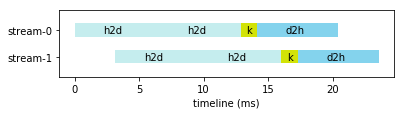

In [28]:
cuda_timeline.plot_cke_list(df_cke_list, savefig=True)

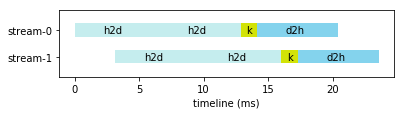

In [29]:
cuda_timeline.plot_cke_list(df_cke_list[0:2])

In [30]:
tot_runtime = read_trace.getTotalRuntime(df_cke_list[0:2])
print tot_runtime

20.432566


# Check the h2d overlapping

In [31]:
# # extract kernel info
# streaminfo = get_stream_info(df_trace)
# current_kern_info = streaminfo[0].kernel_info[0]

# grid_dim = float(current_kern_info.grid_x) * float(current_kern_info.grid_y) * float(current_kern_info.grid_z)
# block_dim = float(current_kern_info.blk_x) * float(current_kern_info.blk_y) * float(current_kern_info.blk_z)
# reg_per_thread = float(current_kern_info.regs_per_thread)
# sm_per_blk = float(current_kern_info.sm_per_block)
    
# # kernel runtime in ms
# current_kern =  streaminfo[0].kernel[0]
# kern_runtime_ms = float(current_kern.end_time_ms) - float(current_kern.start_time_ms)

# kernel = KernelInfo()
# kernel.blockDim = block_dim
# kernel.gridDim = grid_dim
# kernel.reg_per_thread = reg_per_thread
# kernel.sharedmem_per_blk = sm_per_blk
# kernel.runtime_ms = kern_runtime_ms

# kernel.avg_blk_time = compute_avgblktime(gtx950, kernel)
# #print kernel_avg_blk_time

### check whether there is h2d overlapping

In [32]:
prev_stm_h2ds_start, prev_stm_h2ds_end = find_h2ds_timing(df_cke_list[0])
print("prev stream h2ds : {} - {}".format(prev_stm_h2ds_start, prev_stm_h2ds_end))

curr_stm_h2ds_start, curr_stm_h2ds_end = find_h2ds_timing(df_cke_list[1])
print("curr stream h2ds : {} - {}".format(curr_stm_h2ds_start, curr_stm_h2ds_end))

NameError: name 'find_h2ds_timing' is not defined

In [ ]:
if curr_stm_h2ds_start >=prev_stm_h2ds_start and curr_stm_h2ds_start < prev_stm_h2ds_end:
    h2ds_ovlp_between_stream = True 
else:
    h2ds_ovlp_between_stream = False

print("h2ds_ovlp_between_stream : {}".format(h2ds_ovlp_between_stream))

### check kernel overlapping

In [ ]:
prev_stm_kern_start, prev_stm_kern_end = find_kern_timing(df_cke_list[0])
print("prev stream kern : {} - {}".format(prev_stm_kern_start, prev_stm_kern_end))

curr_stm_kern_start, curr_stm_kern_end = find_kern_timing(df_cke_list[1])
print("curr stream kern : {} - {}".format(curr_stm_kern_start, curr_stm_kern_end))


In [ ]:
if  prev_stm_kern_start <= curr_stm_kern_start < prev_stm_kern_end:
    kern_ovlp_between_stream = True 
else:
    kern_ovlp_between_stream = False

print("kern_ovlp_between_stream : {}".format(kern_ovlp_between_stream))

#### use cke model if kern_ovlp_between_stream is true

In [ ]:
# get the overlapping kernel info from both stream

# since the ovlp kernels are identical, we duplicate twice
kernel_num = 2
kernels = [kernel for i in range(kernel_num)]

pred_cke_time, kernels_start_end = model_cke_from_same_kernel(gtx950, kernels)

In [ ]:
pred_cke_time

In [ ]:
kernels_start_end

In [ ]:
df_cke_list[0]

In [ ]:
df_cke_list[1]

In [ ]:
def api_order(df_trace):
    order_ls = []
    for index,row in df_trace.iterrows():
        order_ls.append([str(row.api_type), index])
    return order_ls

In [ ]:
cke1_api_list = api_order(df_cke_list[1])
print cke1_api_list

In [ ]:
def find_api_pos(ls, api_name, order):
    count = 0
    index = 0
    found = 0
    for api in ls:
        if api[0] == api_name:
            count = count + 1
            if count == order:
                found = 1
                index = api[1]
                break;
    return found, index

In [ ]:
# found, pos = find_api_pos(cke1_api_list, "kern", 1)
# print("found : {}, pos : {}".format(found, pos))

In [ ]:
# adjust kernel timing 

df_current = df_cke_list[1]
df_current_kern = df_current.loc[df_current.api_type == "kern"]
#print df_current_kern.start
#print df_current_kern.end

df_prev = df_cke_list[0]
df_prev_kern = df_prev.loc[df_prev.api_type == "kern"]
#print df_prev_kern.start

kern_start_update =  float(df_prev_kern.start) + kernels_start_end[1][0]
print kern_start_update

kern_end_update = float(df_prev_kern.start) + kernels_start_end[1][1]
print kern_end_update

# we need to adjust the timing for the following api calls too
# find out the kern_d2h ovhd
df_current_d2h = df_current.loc[df_current.api_type == "d2h"]
#print df_current_d2h.start
#print df_current_kern.end

kern_d2h_ovhd = float(df_current_d2h.start) - float(df_current_kern.end)
print kern_d2h_ovhd


d2h_new_start = kern_end_update + kern_d2h_ovhd
print d2h_new_start

d2h_delta = d2h_new_start - float(df_current_d2h.start)
print d2h_delta

### update
found, pos = find_api_pos(cke1_api_list, "kern", 1)  # find the 1st kern in the api list
print("found : {}, pos : {}".format(found, pos))

df_current.set_value(pos, 'start', kern_start_update)
df_current.set_value(pos, 'end', kern_end_update)
df_current.set_value(pos, 'duration', kern_end_update - kern_start_update)
#df_current_kern.start = kern_start_update 
#df_current_kern.end = kern_end_update
#df_current_kern.duration = kern_end_update - kern_start_update


found, pos = find_api_pos(cke1_api_list, "d2h", 1)  # find the 1st kern in the api list
print("found : {}, pos : {}".format(found, pos))

df_current.set_value(pos, 'start', d2h_new_start)
df_current.set_value(pos, 'end', df_current_d2h.end + d2h_delta)
#df_current_d2h.start = d2h_new_start
#df_current_d2h.end = df_current_d2h.end + d2h_delta